In [63]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os
import yaml
import unicodedata
import numpy as np



with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

def normalize_text(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    ).lower()


In [56]:
Total_area = read('AQUA_AfricaIrrigation_2000')
CPIS_area = read('Africa_CPIS_2000_Areas_path')

# rename the columns to match CPIS_area 
Total_area.rename(columns={'Area': 'Country'}, inplace = True)
Total_area.rename(columns={'Value': 'Area_1000ha'}, inplace = True)

# drop unncessary columns
Total_area.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace = True)
CPIS_area.drop(columns=['Id', 'Country Co', 'Area_m2'], inplace = True)

# reorder/sort
###year_col = Total_area.pop('Year')
###Total_area['Year'] = year_col
CPIS_area_summed = CPIS_area.groupby('Country', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed['Year'] = 2000

# Save
CPIS_area_summed.to_csv(resolve_path(config['CPIS_Area_by_Country_2000_path']))

print(CPIS_area_summed.head())
print(Total_area.head())

# Drop the year column before merging
Total_area.drop(columns=['Year'], inplace=True)
CPIS_area_summed.drop(columns=['Year'], inplace=True)

        Country  Area_1000ha  Year
0       Algeria    12.009123  2000
1        Angola     0.136167  2000
2      Botswana     0.413488  2000
3  Burkina Faso     2.345775  2000
4          Chad     3.462805  2000
        Country  Year  Area_1000ha
0       Algeria  2000   567.900000
1        Angola  2000    84.608333
2         Benin  2000    11.752500
3      Botswana  2000     1.427400
4  Burkina Faso  2000    24.647778


In [58]:
# Merge the total and CPIS data into the same dataframe
merged_data = Total_area.merge(CPIS_area_summed, how='left', on='Country', suffixes=('_total', '_CPIS'))

print(merged_data.head())
print('-------')

# Add zeros for countries with no CPIS data
merged_data['Area_1000ha_CPIS'] = merged_data['Area_1000ha_CPIS'].fillna(0)

print(merged_data.head())
print('-------')


# Add column for the percent of irrigation that CPIS accounts for in each country
merged_data['Percent_CPIS'] = (merged_data['Area_1000ha_CPIS'] / merged_data['Area_1000ha_total']) * 100

print(merged_data.head())

# Add the year column back
###merged_data['Year'] = 2000

# Save
merged_data.to_csv(resolve_path(config['Comp_by_Country_2000_path']))


        Country  Area_1000ha_total  Area_1000ha_CPIS
0       Algeria         567.900000         12.009123
1        Angola          84.608333          0.136167
2         Benin          11.752500               NaN
3      Botswana           1.427400          0.413488
4  Burkina Faso          24.647778          2.345775
-------
        Country  Area_1000ha_total  Area_1000ha_CPIS
0       Algeria         567.900000         12.009123
1        Angola          84.608333          0.136167
2         Benin          11.752500          0.000000
3      Botswana           1.427400          0.413488
4  Burkina Faso          24.647778          2.345775
-------
        Country  Area_1000ha_total  Area_1000ha_CPIS  Percent_CPIS
0       Algeria         567.900000         12.009123      2.114655
1        Angola          84.608333          0.136167      0.160938
2         Benin          11.752500          0.000000      0.000000
3      Botswana           1.427400          0.413488     28.967940
4  Burkina Fa

In [64]:

# Load the shapefile for Africa boundaries
africa_boundaries = geo_read('Africa_boundaries_shp_path')

africa_boundaries['Country'] = africa_boundaries['Country'].apply(normalize_text)

# Check the first few rows to understand the data structure
print("Shapefile data:")
print(africa_boundaries.head())
print(africa_boundaries.columns)

cpis_data = read('Comp_by_Country_2000_path')

cpis_data['Country']=cpis_data['Country'].apply(normalize_text)

# Check the first few rows to understand the data structure
print("CSV data:")
print(cpis_data.head())
print(cpis_data.columns)

# Ensure the column names match for merging
# For this example, we'll assume the common column in the shapefile is 'NAME' and in the CSV is 'Country'
africa_boundaries = africa_boundaries.rename(columns={'NAME': 'Country'})

# Merge the shapefile GeoDataFrame with the CSV DataFrame
merged_data = africa_boundaries.merge(cpis_data, on='Country', how='left')

# Check the first few rows of the merged data
print("Merged data:")
print(merged_data.head())
print(merged_data.columns)

# Check for any missing values in the merged data
missing_countries = merged_data[merged_data['Percent_CPIS'].isnull()]
print("Countries with missing data after merge:")
print(missing_countries[['Country']])

# Check for any missing values in the merged data
missing_countries = merged_data[merged_data['Percent_CPIS'].isnull()]
print("Countries with missing data after merge:")
print(missing_countries[['Country']])

print("Normalized shapefile data:")
print(africa_boundaries.head())
print("Normalized CSV data:")
print(cpis_data.head())

merged_data['Percent_CPIS'] = np.where(
    merged_data['Area_1000ha_total'] == 0,
    0,
    merged_data['Area_1000ha_CPIS'] / merged_data['Area_1000ha_total'] * 100
)

# Verify the data after handling division by zero
print("Data after handling division by zero:")
merged_data['Percent_CPIS']=merged_data['Percent_CPIS'].fillna(0)

print(merged_data[['Country', 'Area_1000ha_total', 'Area_1000ha_CPIS', 'Percent_CPIS']])


Shapefile data:
  Country Co                      Country  \
0        AGO                       angola   
1        ATF  french southern territories   
2        BDI                      burundi   
3        BEN                        benin   
4        BFA                 burkina faso   

                                            geometry  
0  MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -...  
1  MULTIPOLYGON (((68.86333 -50.01889, 68.86166 -...  
2  POLYGON ((30.41152 -2.31061, 30.41243 -2.31180...  
3  MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287...  
4  POLYGON ((-0.45567 15.08082, -0.44206 15.06812...  
Index(['Country Co', 'Country', 'geometry'], dtype='object')
CSV data:
   Unnamed: 0       Country  Area_1000ha_total  Area_1000ha_CPIS  Percent_CPIS
0           0       algeria         567.900000         12.009123      2.114655
1           1        angola          84.608333          0.136167      0.160938
2           2         benin          11.752500          0.000000      0.000

C:\Users\ermil\AppData\Local\Temp\ipykernel_34796\2157255095.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)


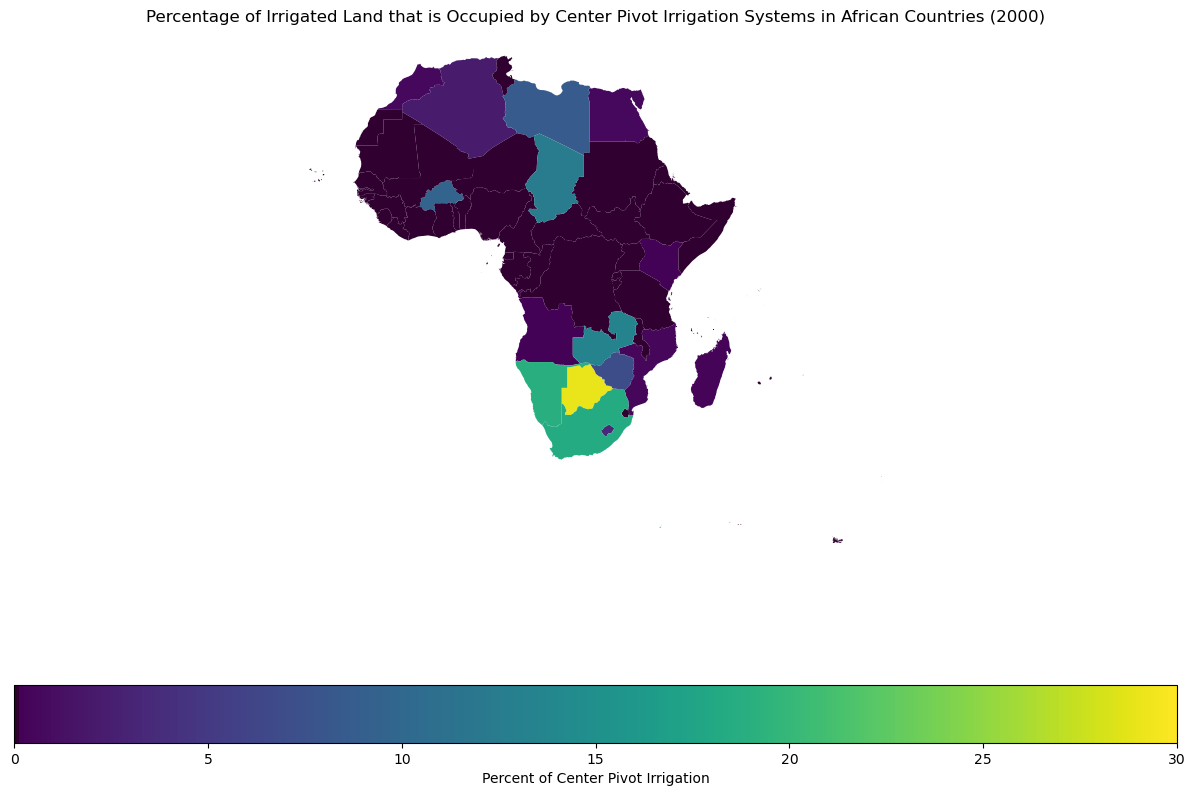

In [83]:
# Custom colormap: dark purple for zero values, viridis otherwise
viridis = plt.cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
dark_purple = np.array([48/255, 0/255, 48/255, 1]) 
newcolors[0, :] = dark_purple  # Set the color for 0 to black
custom_cmap = ListedColormap(newcolors)

# plot the merged map
fig, ax = plt.subplots(1, 1, figsize=(15,10))
merged_data.plot(column='Percent_CPIS', ax=ax, legend=True, 
                 cmap = custom_cmap, vmin = 0, vmax = 30,
                 legend_kwds={'label': "Percent of Center Pivot Irrigation",
                             'orientation': "horizontal"})

# Remove the axis
ax.set_axis_off()

# Give it a title
plt.title("Percentage of Irrigated Land that is Occupied by Center Pivot Irrigation Systems in African Countries (2000)")

plt.show()
